**<h2> Anggota <h2>**

1.   **[202110370311075 - Jasmin Putri Jelita]**
2.   **[202110370311443 - Nazilullaily Nur Aisyah]**
3.   **[202110370311482 - Valencia Sefiana Putri]**

# **Load Dataset**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2, SelectKBest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Langkah pertama yaitu membaca file CSV dan menampilkan 10 baris pertama dari dataset stroke prediction menggunakan library Pandas

In [ ]:
#new_data = pd.read_csv("/content/drive/MyDrive/Dataset/healthcare-dataset-stroke-data.csv")
new_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv")
new_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **Pre-Processing**

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
new_data = new_data.drop('id', axis=1)

##DATA CLEANING

Melakukan pengecekan missing value, dari output tersebut diketahui terdapat missing value pada feature bmi sebanyak 201

In [ ]:
new_data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Oleh karena itu, dilakukan data cleaning untuk mengisi missing value menggunakan nilai median dari feature bmi.

In [ ]:
new_data['bmi']=new_data['bmi'].fillna(new_data['bmi'].median())
new_data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Data Discretization


Data discretization ini dilakukan untuk mengelompokkan nilai-nilai numerik ke dalam rentang nilai tertentu.
1. feature **age** menjadi:
  - Anak-anak: 0-18 tahun
  - Dewasa: 19-60 tahun
  - Lansia: >60 tahun
2. feature **avg_glucose_level** menjadi:
  - Normal: <100 mg/dL
  - Pra-diabetes: 100-125 mg/dL
  - Diabetes: >=126 mg/dL
3. feature **bmi** menjadi:
  - Underweight: <18.5
  - Normal: 18.5-24.9
  - Overweight: 25-29.9
  - Obesitas: >=30

In [ ]:
age_col = "age"
new_data["age_category"] = pd.cut(new_data[age_col], bins=[0, 18, 60, np.inf], labels=["anak-anak", "dewasa", "lansia"])

glucose_col = "avg_glucose_level"
new_data["glucose_category"] = pd.cut(new_data[glucose_col], bins=[0, 100, 125, np.inf], labels=["normal", "pra-diabetes", "diabetes"])

bmi_col = "bmi"
new_data["bmi_category"] = pd.cut(new_data[bmi_col], bins=[0, 18.5, 24.9, 29.9, np.inf], labels=["underweight", "normal", "overweight", "obesitas"])

print(new_data)

      gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi   smok

Kode di bawah digunakan untuk membuat box plot dari kolom "bmi" sebagai alat visualisasi data yang membantu dalam memahami distribusi, mendeteksi outlier, serta melihat perbedaan kuartil (Q1, median/Q2, dan Q3) dari data.

# EDA

In [ ]:
print(new_data.describe())

               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  5110.000000  5110.000000  
mean     28.862035     0.048728  
std       7.699562     0.215320  
min      10.300000     0.000000  
25%      23.800000     0.000000  
50%      28.100000     0.000000  
75%      32.800000     0.000000  
max      97.600000     1.000000  


In [ ]:
new_data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_category', 'glucose_category',
       'bmi_category'],
      dtype='object')

In [ ]:
# Value Counts
print(new_data['gender'].value_counts())
print(new_data['ever_married'].value_counts())
print(new_data['work_type'].value_counts())
print(new_data['Residence_type'].value_counts())
print(new_data['smoking_status'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


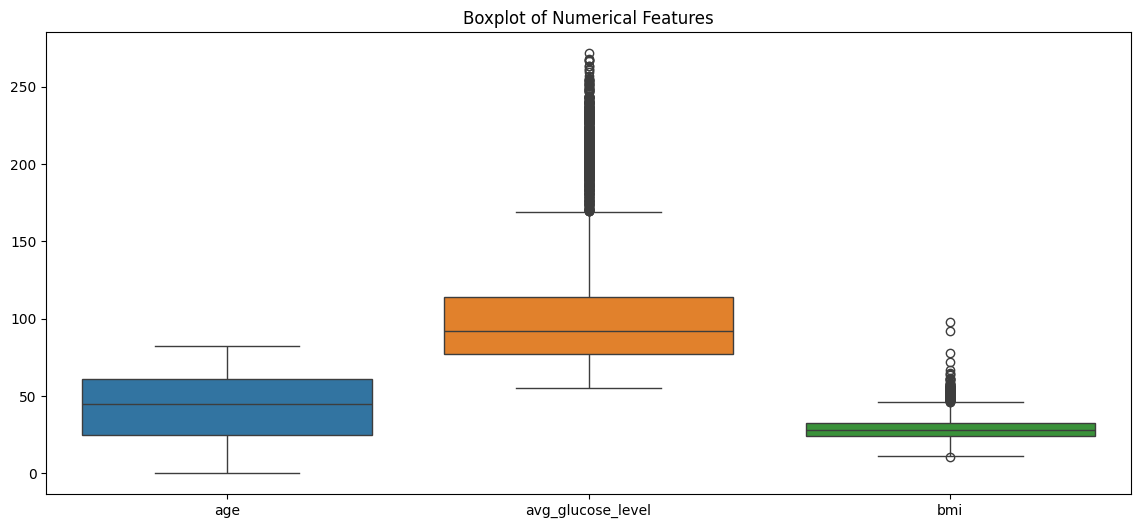

In [ ]:
# Distribution of Numerical Features
plt.figure(figsize=(14, 6))
sns.boxplot(data=new_data[['age', 'avg_glucose_level', 'bmi']])
plt.title('Boxplot of Numerical Features')
plt.show()

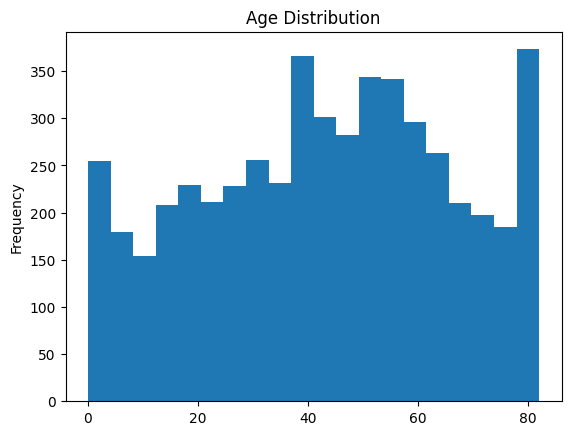

In [ ]:
new_data['age'].plot.hist(title='Age Distribution', bins=20)
plt.show()

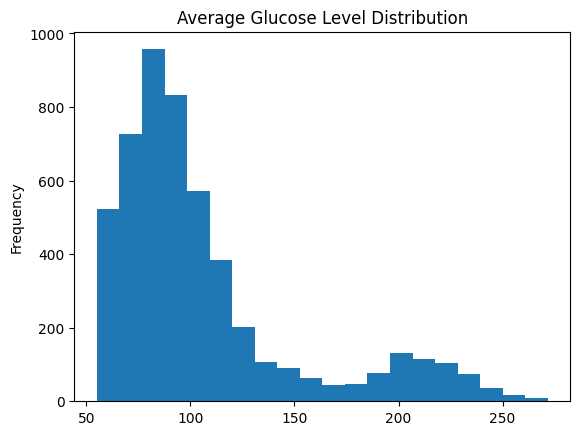

In [ ]:
new_data['avg_glucose_level'].plot.hist(title='Average Glucose Level Distribution', bins=20)
plt.show()

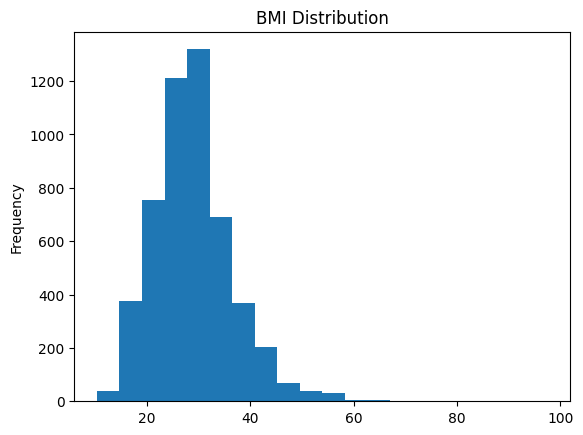

In [ ]:
new_data['bmi'].plot.hist(title='BMI Distribution', bins=20)
plt.show()

<ipython-input-16-5840594f3fbf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="gender", data=new_data, palette="Blues")


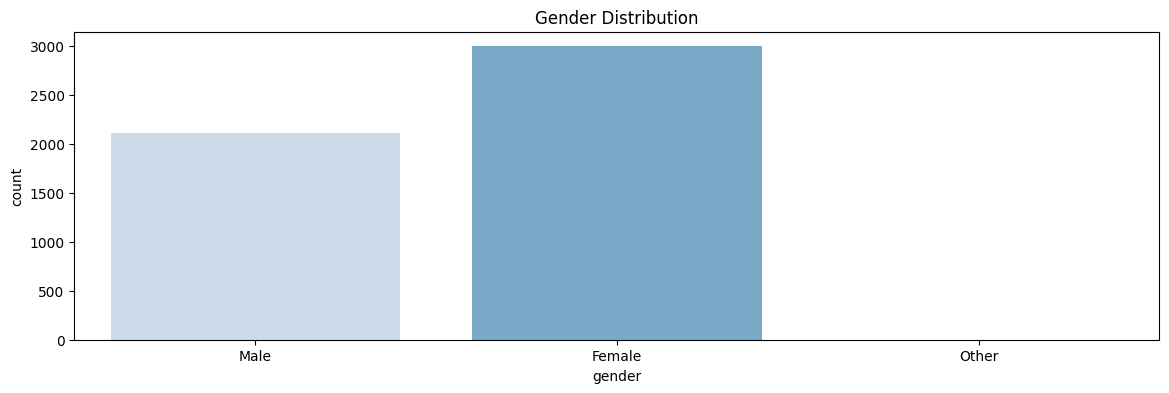

In [ ]:
# Count Plots for Categorical Features
plt.figure(figsize=(14, 4))
sns.countplot(x="gender", data=new_data, palette="Blues")
plt.title('Gender Distribution')
plt.show()

<ipython-input-17-1ba3b97613cb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="ever_married", data=new_data, palette="Blues")


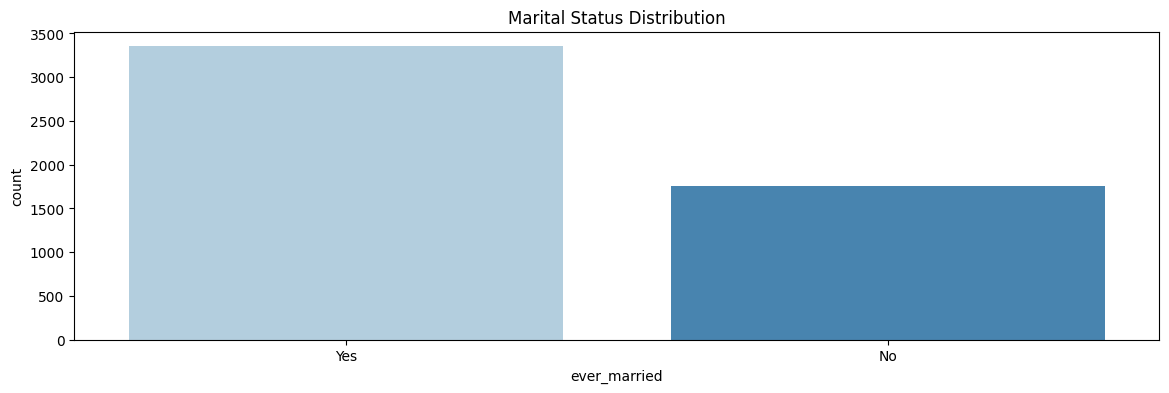

In [ ]:
plt.figure(figsize=(14, 4))
sns.countplot(x="ever_married", data=new_data, palette="Blues")
plt.title('Marital Status Distribution')
plt.show()

<ipython-input-18-a74cac4a4412>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="work_type", data=new_data, palette="Blues")


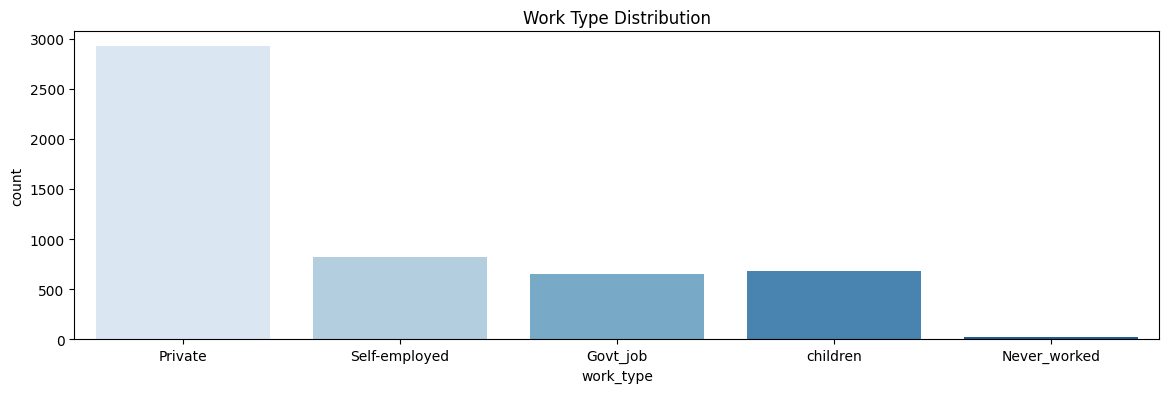

In [ ]:
plt.figure(figsize=(14, 4))
sns.countplot(x="work_type", data=new_data, palette="Blues")
plt.title('Work Type Distribution')
plt.show()

<ipython-input-19-6dbea65137e6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Residence_type", data=new_data, palette="Blues")


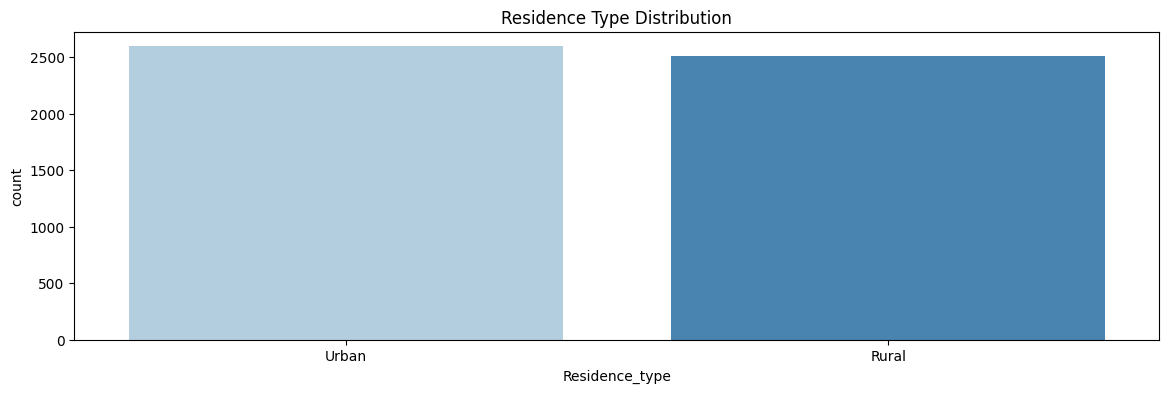

In [ ]:
plt.figure(figsize=(14, 4))
sns.countplot(x="Residence_type", data=new_data, palette="Blues")
plt.title('Residence Type Distribution')
plt.show()

<ipython-input-20-1ea44ab91190>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="smoking_status", data=new_data, palette="Blues")


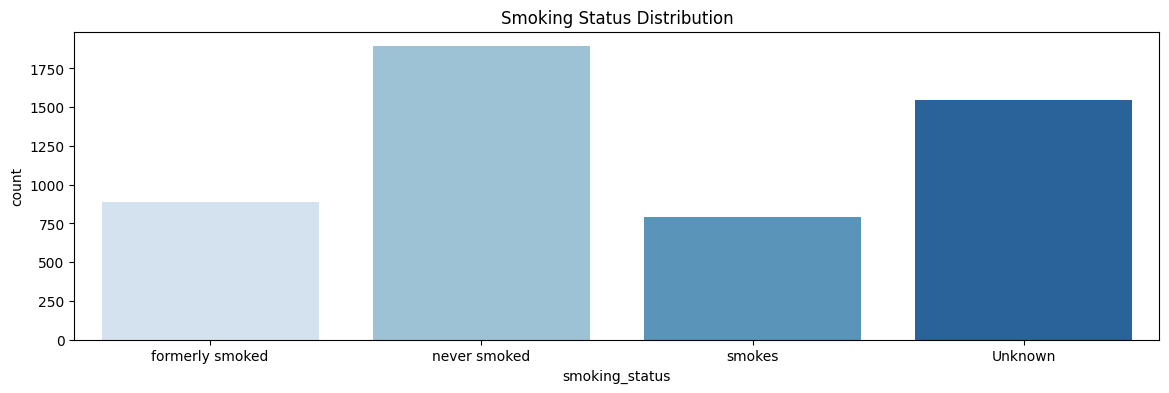

In [ ]:
plt.figure(figsize=(14, 4))
sns.countplot(x="smoking_status", data=new_data, palette="Blues")
plt.title('Smoking Status Distribution')
plt.show()

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


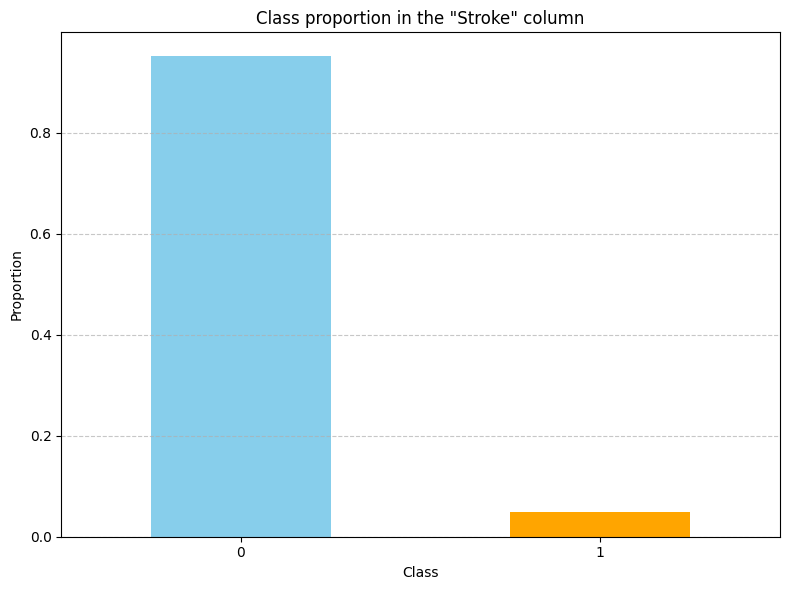

In [ ]:
label_proportion = new_data["stroke"].value_counts(normalize=True)
print(label_proportion)
plt.figure(figsize=(8, 6))
label_proportion.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class proportion in the "Stroke" column')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['0', '1'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

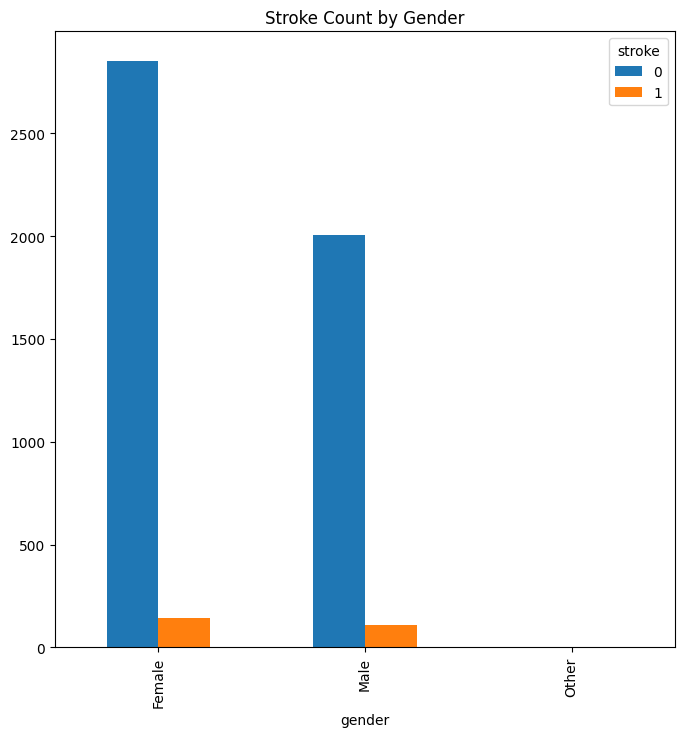

In [ ]:
# Crosstabs and Count Plots
gender_stroke = pd.crosstab(new_data['gender'], new_data['stroke'])
gender_stroke.plot(kind='bar', figsize=(8, 8))
plt.title('Stroke Count by Gender')
plt.show()

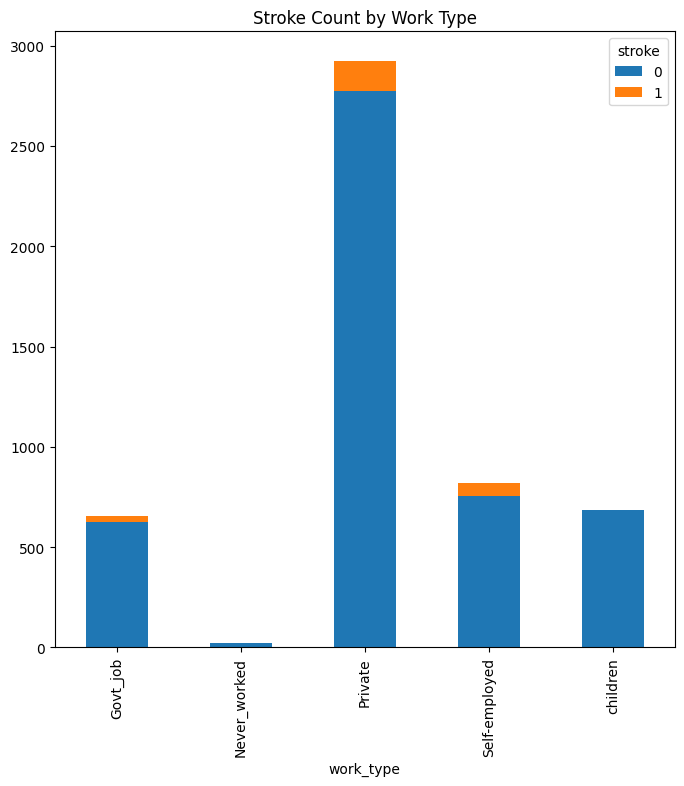

In [ ]:
worktype_stroke = pd.crosstab(new_data['work_type'], new_data['stroke'])
worktype_stroke.plot(kind='bar', figsize=(8, 8), stacked=True)
plt.title('Stroke Count by Work Type')
plt.show()

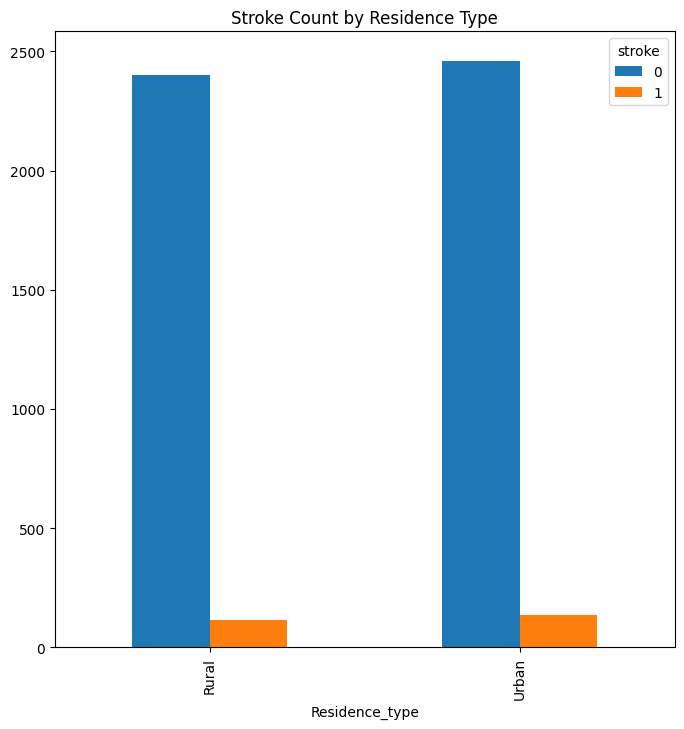

In [ ]:
residence_stroke = pd.crosstab(new_data['Residence_type'], new_data['stroke'])
residence_stroke.plot(kind='bar', figsize=(8, 8))
plt.title('Stroke Count by Residence Type')
plt.show()

##Label Encoder

In [ ]:
new_col = ["gender", "ever_married" ,"Residence_type","smoking_status","work_type", "age_category", "glucose_category", "bmi_category",]
new_encoder = preprocessing.LabelEncoder()
for col in new_col:
    new_data[col]=  new_encoder.fit_transform(new_data[col])

##Heatmap

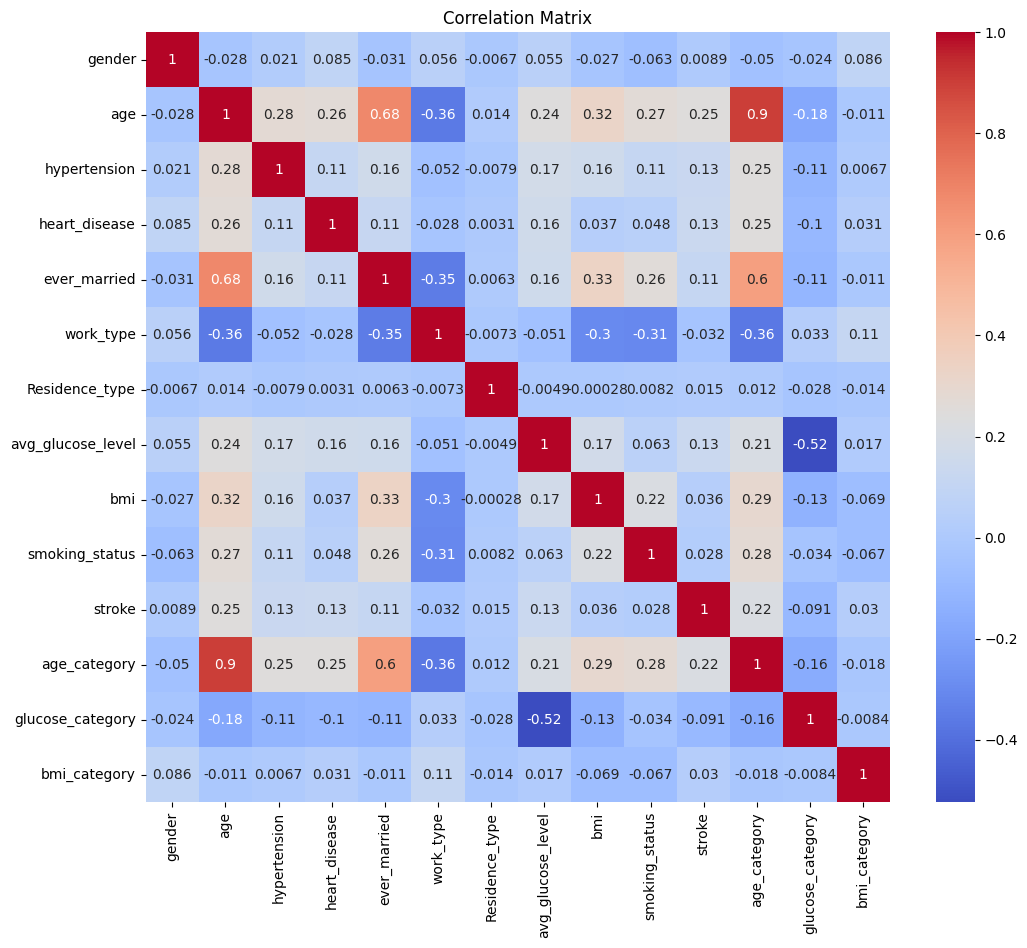

In [ ]:
# Heatmap for Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(new_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ALGORITMA DATA MINING TASK

## 1. Logistic Regression

In [ ]:
## To drop the predictor variable 'stroke' from the independent variables for
x = new_data.drop(['stroke'],axis=1)
y = new_data['stroke']

In [ ]:
x.shape

(5110, 13)

In [ ]:
y.shape

(5110,)

SMOTE
Kode di bawah digunakan untuk mengatasi masalah ketidakseimbangan kelas dalam dataset menggunakan teknik oversampling dengan SMOTE

In [ ]:
smote = SMOTE(random_state=123)
x_oversampling, y_oversampling = smote.fit_resample(x, y)

Kode di bawah digunakan untuk membagi dataset yang telah di-oversampling menjadi set pelatihan (training set) dan set pengujian (testing set).

In [ ]:
#oversampling = SMOTE(random_state=123)
#menerapkan SMOTE untuk membuat sampel sintetis dari kelas minoritas dan menyeimbangkan distribusi kelas.
#x_oversampling , y_oversampling = oversampling.fit_resample(x,y)

print(f'''Before SMOTE:{x.shape}
After SMOTE:{x_oversampling.shape}''',"\n")

print(f'''Distribution before SMOTE:\n{y.value_counts(normalize=True)}
Distribution after SMOTE :\n{y_oversampling.value_counts(normalize=True)}''')

Before SMOTE:(5110, 13)
After SMOTE:(9722, 13) 

Distribution before SMOTE:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
Distribution after SMOTE :
stroke
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_oversampling, y_oversampling, test_size=0.3, random_state=0)

In [ ]:
## To represent the number of observations after splitting.
x_train.shape,x_test.shape

((6805, 13), (2917, 13))

In [ ]:
# To count the total number of strokes present in our data frame.
new_data['stroke'].value_counts()


stroke
0    4861
1     249
Name: count, dtype: int64

In [ ]:
## Standard scaler is used for normalization of our training and testing data.
sca = StandardScaler()
x_train = sca.fit_transform(x_train)
x_test = sca.transform(x_test)

In [ ]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (6805, 13)
y_train shape: (6805,)
x_test shape: (2917, 13)
y_test shape: (2917,)


In [ ]:
from sklearn.linear_model import LogisticRegression as LgRg
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,precision_score,recall_score

Kode di bawah digunakan untuk melatih dan mengevaluasi model machine learning menggunakan Logistic Regression

In [ ]:
#membuat instance dari model Logistic Regression
lg= LgRg()

#melatih model Logistic Regression menggunakan data pelatihan (x_train dan y_train).
lg.fit(x_train,y_train)

#membuat prediksi pada data pengujian (x_test) menggunakan model yang telah dilatih
y_lg_pred = lg.predict(x_test)

#menghitung akurasi prediksi dan mengonversinya ke persentase
score_lg=accuracy_score(y_test,y_lg_pred)*100
print("training accuracy score: ",accuracy_score(y_train,lg.predict(x_train))*100)
print("testing accuracy score: ",score_lg)

#mencetak skor F1 pada data train
print("F1 score", f1_score(y_train,lg.predict(x_train)))

training accuracy score:  82.40999265246143
testing accuracy score:  82.85910181693521
F1 score 0.8298507462686567


In [ ]:
# Predicting Feature Importance of Logistic Regression Model
imp = lg.coef_[0]

 Kode di bawah digunakan untuk mencetak informasi tentang seberapa pentingnya setiap feature dalam model yang telah dibuat.

In [ ]:
for i,v in enumerate(imp):
    print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: -0.37902
Feature: 1, Score: 3.25778
Feature: 2, Score: -0.29575
Feature: 3, Score: -0.21427
Feature: 4, Score: -0.50755
Feature: 5, Score: -0.29688
Feature: 6, Score: -0.51282
Feature: 7, Score: 0.35419
Feature: 8, Score: 0.04716
Feature: 9, Score: -0.32241
Feature: 10, Score: -1.14856
Feature: 11, Score: -0.08102
Feature: 12, Score: 0.05949


In [ ]:
from sklearn.metrics import classification_report

y_new = lg.predict_proba(x_test)[:,1] >= 0.7

report = classification_report(y_test, y_new)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.90      0.81      1450
           1       0.87      0.70      0.78      1467

    accuracy                           0.80      2917
   macro avg       0.81      0.80      0.80      2917
weighted avg       0.81      0.80      0.80      2917



Kode di bawah digunakan untuk membuat bar plot yang menampilkan pentingnya setiap feature dalam model yang telah dilatih. Dengan ber plot ini, dapat langsung dilihat seberapa penting setiap ffeature. Semakin tinggi batangnya, semakin penting fitur itu dalam membuat prediksi yang akurat.

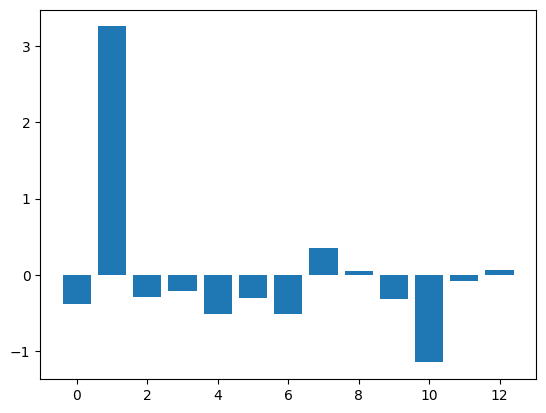

In [ ]:
plt.bar([x for x in range(len(imp))], imp)
plt.show()

##  2. Decision Tree Classifier

In [ ]:
# Performing Decision Tree Classifier with Random State = 20
from sklearn.tree import DecisionTreeClassifier
dt_model=DecisionTreeClassifier(random_state=20)


Kode di bawah digunakan untuk melatih model Decision Tree (dt_model) menggunakan data pelatihan (x_train dan y_train)

In [ ]:
dt_model.fit(x_train,y_train)

DecisionTreeClassifier(random_state=20)

In [ ]:
# Predicting the score of our Decision Tree Classifier on Training DataFrame
dt_model.score(x_train,y_train)

1.0

Kode di bawah digunakan untuk menghitung akurasi model Decision Tree (dt_model) pada data pengujian (x_test dan y_test).

In [ ]:
dt_model.score(x_test,y_test)

0.9136098731573534

Kode di dibawah digunakan untuk membuat prediksi menggunakan model Decision Tree (dt_model) pada data pelatihan (x_train).

In [ ]:
dt_model.predict(x_train)

array([1, 0, 0, ..., 0, 0, 0])

Kode dibawah digunakan untuk memprediksi nilai target dari data pelatihan (x_train) menggunakan model Decision Tree (dt_model).

In [ ]:
dt_model.predict_proba(x_test)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

Kode di bawah digunakan untuk memperoleh probabilitas prediksi dari kelas positif (1) dari model Decision Tree (dt_model) untuk setiap sampel dalam data pengujian (x_test):
- dt_model.predict_proba(x_test): Menghasilkan probabilitas prediksi untuk setiap kelas target untuk setiap sampel dalam data test. Hasilnya adalah matriks dengan dua kolom, di mana kolom pertama berisi probabilitas prediksi untuk kelas 0 (negatif) dan kolom kedua berisi probabilitas prediksi untuk kelas 1 (positif).

- [:,1]: Ini memilih semua baris dari kolom kedua (indeks 1), yang berisi probabilitas prediksi untuk kelas positif. Dengan demikian, diperoleh array yang berisi probabilitas prediksi untuk kelas positif dari setiap sampel dalam data pengujian.

In [ ]:
y_pred=dt_model.predict_proba(x_test)[:,1]


Kode di bawah digunakan untuk membuat klasifikasi berdasarkan probabilitas prediksi yang dihasilkan oleh model Decision Tree. Hasilnya adalah list y_new yang berisi klasifikasi baru berdasarkan probabilitas prediksi dari model Decision Tree, dengan threshold probabilitas sebesar 0.7.

In [ ]:
# Membuat list kosong
y_new=[]

#Iterasi melalui setiao probabilitas prediksi
for i in range(len(y_pred)):
  #Memeriksa apakah probabilitas prediksi untuk sampel ke-i <= 0.7. Jika ya, maka klasifikasikan sampel tersebut sebagai kelas 0 (negatif).
 if y_pred[i]<=0.7:
    y_new.append(0)
    # Jika probabilitas prediksi untuk sampel ke-i > 0.7, maka klasifikasikan sampel tersebut sebagai kelas 1 (positif).
 else:
    y_new.append(1)


Kode di bawah digunakan untuk menghitung akurasi dari klasifikasi baru (y_new) yang dibuat berdasarkan probabilitas prediksi model Decision Tree terhadap data pengujian (y_test). Hasilnya adalah skor akurasi, yang mencerminkan seberapa baik klasifikasi baru (y_new) berhasil memprediksi label target sebenarnya (y_test). Semakin tinggi skornya, semakin baik klasifikasi baru tersebut dalam memprediksi label target yang benar.

In [ ]:
accuracy_score(y_test,y_new)


0.9136098731573534

Kode di atas digunakan untuk menghitung akurasi model Decision Tree pada data train dan data test untuk berbagai kedalaman maksimum (max_depth) yang berbeda

In [ ]:
# Membuat list kosong
train_accuracy=[]
test_accuracy=[]

#Melakukan iterasi dari kedalaman maks 1-9.
for depth in range(1,10):
 dt_model=DecisionTreeClassifier(max_depth=depth,random_state=20)
 dt_model.fit(x_train,y_train)
 train_accuracy.append(dt_model.score(x_train,y_train))
 test_accuracy.append(dt_model.score(x_test,y_test))


Kode di bawah digunakan untuk membuat DataFrame frame yang berisi skor akurasi dari model Decision Tree pada data train dan test untuk berbagai nilai kedalaman maksimum yang berbeda. Dengan DataFrame ini, dapat dialisis bagaimana skor akurasi pada data train dan test berubah seiring dengan peningkatan kedalaman maksimum model Decision Tree.

In [ ]:
frame=pd.DataFrame({'max_depth':range(1,10),'train_acc':train_accuracy,'test_cc':test_accuracy})
frame.head()

,max_depth,train_acc,test_cc
0,1,0.772079,0.786082
1,2,0.772079,0.786082
2,3,0.789273,0.805279
3,4,0.801470,0.811107
4,5,0.827627,0.836819


Kode di bawah bertujuan untuk memvisualisasikan kinerja model Decision Tree pada data train dan test untuk berbagai kedalaman maksimum yang berbeda.

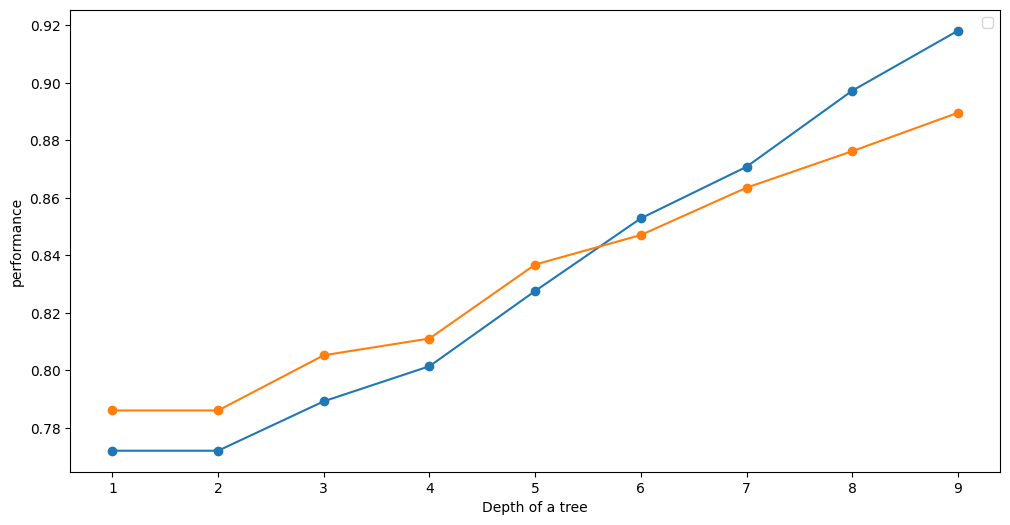

In [ ]:
# Finding the Depth Of Tree to optimize the Decision Tree Classifier
plt.figure(figsize=(12,6))
plt.plot(frame['max_depth'],frame['train_acc'],marker='o')
plt.plot(frame['max_depth'],frame['test_cc'],marker='o')
plt.xlabel('Depth of a tree')
plt.ylabel('performance')
plt.legend()


In [ ]:
# Predicting Feature Importance of Decision Tree Classifier
imp3 = dt_model.feature_importances_

In [ ]:
for i,v in enumerate(imp3):
        print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01864
Feature: 1, Score: 0.57015
Feature: 2, Score: 0.00868
Feature: 3, Score: 0.01665
Feature: 4, Score: 0.01732
Feature: 5, Score: 0.06388
Feature: 6, Score: 0.02717
Feature: 7, Score: 0.13155
Feature: 8, Score: 0.07869
Feature: 9, Score: 0.02538
Feature: 10, Score: 0.02255
Feature: 11, Score: 0.00452
Feature: 12, Score: 0.01483


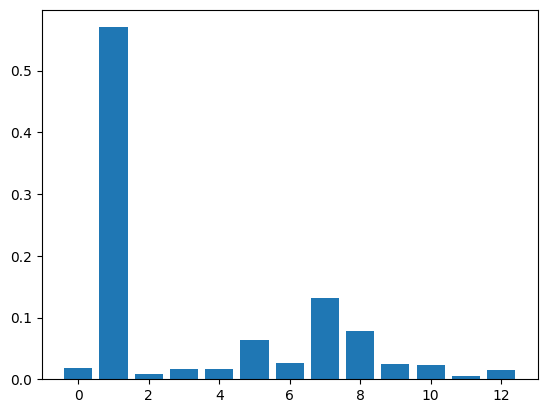

In [ ]:
# Plotting Feature Importance of Decision Tree Classifier
plt.bar([x for x in range(len(imp3))], imp3)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Evaluasi model
report = classification_report(y_test, y_new)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1450
           1       0.90      0.93      0.92      1467

    accuracy                           0.91      2917
   macro avg       0.91      0.91      0.91      2917
weighted avg       0.91      0.91      0.91      2917



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
pip install pandas numpy seaborn matplotlib scikit-learn xgboost

## 3. XGboost

In [ ]:
# XGBoost
xgboost = xgb.XGBClassifier()
xgboost.fit(x_train, y_train)
xgboost_pred = xgboost.predict(x_test)
print("Akurasi XGBoost:", accuracy_score(y_test, xgboost_pred))
print(confusion_matrix(y_test, xgboost_pred))
print(classification_report(y_test, xgboost_pred))

Akurasi XGBoost: 0.9568049365786767
[[1375   75]
 [  51 1416]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1450
           1       0.95      0.97      0.96      1467

    accuracy                           0.96      2917
   macro avg       0.96      0.96      0.96      2917
weighted avg       0.96      0.96      0.96      2917



## 4. Naive Bayes

In [ ]:
naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)
naive_bayes_pred = naive_bayes.predict(x_test)
print("Akurasi Naive Bayes:", accuracy_score(y_test, naive_bayes_pred))
print(confusion_matrix(y_test, naive_bayes_pred))
print(classification_report(y_test, naive_bayes_pred))

Akurasi Naive Bayes: 0.7853959547480288
[[1074  376]
 [ 250 1217]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1450
           1       0.76      0.83      0.80      1467

    accuracy                           0.79      2917
   macro avg       0.79      0.79      0.78      2917
weighted avg       0.79      0.79      0.78      2917



## 5. Random Forest

In [ ]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
random_forest_pred = random_forest.predict(x_test)
print("Akurasi Random Forest:", accuracy_score(y_test, random_forest_pred))
print(confusion_matrix(y_test, random_forest_pred))
print(classification_report(y_test, random_forest_pred))

Akurasi Random Forest: 0.9530339389784025
[[1360   90]
 [  47 1420]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1450
           1       0.94      0.97      0.95      1467

    accuracy                           0.95      2917
   macro avg       0.95      0.95      0.95      2917
weighted avg       0.95      0.95      0.95      2917



# FEATURES SELECTION

Pada Eksperimen ini kami menggunakan tiga features selection yaitu, Chi-Square, SFS-Forward, dan SFS-Backward yang kemudian diuji menggunakan model Logistic Regression, Decision Tree, Naive Bayes, Random Forest, dan XGBoost.

###CHI SQUARE

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

              Feature  Chi2 Score
1                 age  253.004159
10       age_category  242.631602
6      Residence_type  171.454232
7   avg_glucose_level   95.020895
0              gender   76.847711
11   glucose_category   75.854911
4        ever_married   45.058430
5           work_type   36.648584
9      smoking_status   17.559373
8                 bmi    1.777460
2        hypertension    0.662980
3       heart_disease    0.142443
12       bmi_category    0.100603


<ipython-input-65-1989bf5e591c>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2 Score', y='Feature', data=feature_scores, palette="Blues_d")


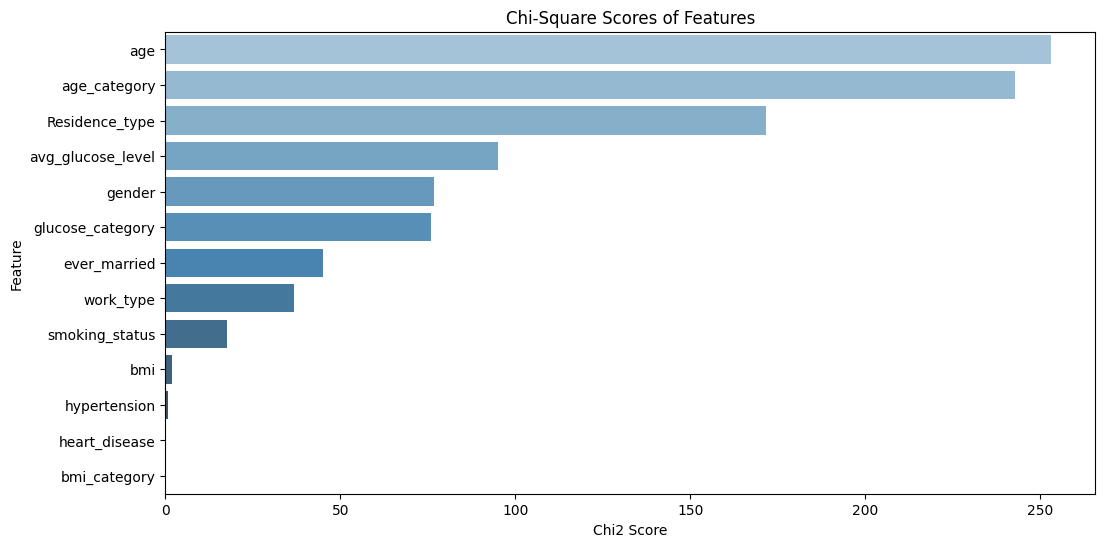

In [ ]:
# Convert training and testing data to DataFrames
x_train_df = pd.DataFrame(x_train, columns=x_oversampling.columns)
x_test_df = pd.DataFrame(x_test, columns=x_oversampling.columns)

# Scale data to [0, 1] for chi2 feature selection
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_df)
x_test_scaled = scaler.transform(x_test_df)

# Apply SelectKBest with chi2 score function
chi2_selector = SelectKBest(score_func=chi2, k='all')
X_kbest_train = chi2_selector.fit_transform(x_train_scaled, y_train)

# Get chi2 scores
chi2_scores = chi2_selector.scores_

# Create DataFrame for scores
feature_scores = pd.DataFrame({'Feature': x_train_df.columns, 'Chi2 Score': chi2_scores})
feature_scores = feature_scores.sort_values(by='Chi2 Score', ascending=False)

# Display scores
print(feature_scores)

# Visualize scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2 Score', y='Feature', data=feature_scores, palette="Blues_d")
plt.title('Chi-Square Scores of Features')
plt.show()

## 1. LOGISTIC REGGRESSION

###CHI SQUARE

In [ ]:
from sklearn.linear_model import LogisticRegression

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

results = []
num_features = x_train_scaled.shape[1]

for k in range(1, num_features + 1):
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_train = chi2_selector.fit_transform(x_train_scaled, y_train)
    X_kbest_test = chi2_selector.transform(x_test_scaled)
    selected_indices = chi2_selector.get_support(indices=True)
    selected_features = [x_train_df.columns[i] for i in selected_indices]

    lr = LogisticRegression(max_iter=1000, random_state=0)
    lr.fit(X_kbest_train, y_train)

    y_pred_test = lr.predict(X_kbest_test)

    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']


    results.append((k, selected_features, accuracy_from_report, report))

# Displaying results for the best number of features
for result in results:
    k, selected_features, accuracy_from_report, report = result
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_features}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    print("\n")

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.7713404182379157
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1450
           1       0.81      0.85      0.83      1467

    accuracy                           0.83      2917
   macro avg       0.83      0.82      0.82      2917
weighted avg       0.83      0.83      0.82      2917



Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.7915666780939321
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1450
           1       0.81      0.85      0.83      1467

    accuracy                           0.83      2917
   macro avg       0.83      0.82      0.82      2917
weighted avg       0.83      0.83      0.82      2917



Number of features selected: 3
Selected features: ['age', 'Residence_type', 'age_category']
Mo

In [ ]:
# Menentukan hasil terbaik berdasarkan akurasi
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, y_pred_test = best_result
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.8251628385327391


### SFS-FORWARD

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.7612049963262307
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3411
           1       0.74      0.80      0.77      3394

    accuracy                           0.76      6805
   macro avg       0.76      0.76      0.76      6805
weighted avg       0.76      0.76      0.76      6805



Number of features selected: 2
Selected features: ['age', 'hypertension']
Model Accuracy: 0.7791329904481998
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      3411
           1       0.75      0.83      0.79      3394

    accuracy                           0.78      6805
   macro avg       0.78      0.78      0.78      6805
weighted avg       0.78      0.78      0.78      6805



Number of features selected: 3
Selected features: ['age', 'hypertension', 'age_category']
Mode

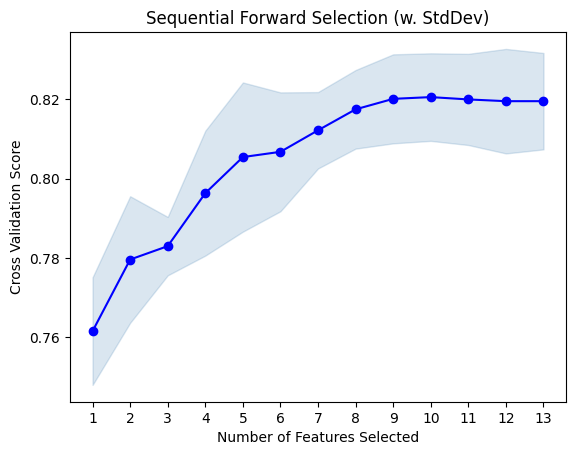

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Sequential forward selection
sfs = SFS(lr,
          k_features='best',  # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)  # using 5-fold cross-validation

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Mendapatkan nama fitur yang dipilih
feature_names = new_data.drop('stroke', axis=1).columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])

    # Mengubah x_train_scaled kembali menjadi DataFrame
    x_train_df = pd.DataFrame(x_train_scaled, columns=feature_names)
    x_selected = x_train_df.iloc[:, selected_indices]

    lr.fit(x_selected, y_train)
    y_pred = lr.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()

In [ ]:
# Menentukan hasil terbaik
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_feature_names, accuracy_from_report, report, y_pred
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_feature_names}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(classification_report(y_train, y_pred, zero_division=0))

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.821601763409258
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3411
           1       0.80      0.86      0.83      3394

    accuracy                           0.82      6805
   macro avg       0.82      0.82      0.82      6805
weighted avg       0.82      0.82      0.82      6805



### SFS-BACKWARD

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.821601763409258
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3411
           1       0.80      0.86      0.83      3394

    accuracy                           0.82      6805
   macro avg       0.82      0.82      0.82      6805
weighted avg       0.82      0.82      0.82      6805



Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'bmi_category']
Model Accuracy: 0.8230712711241734
Classification Report:
              precision    recall  f1-score   support

           0       0.85    

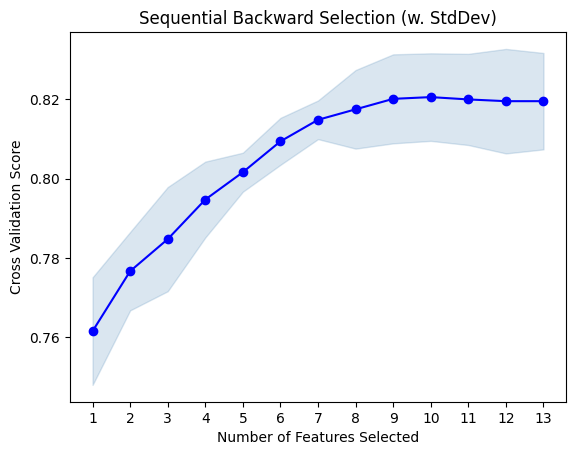

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic regression model
lr = LogisticRegression(max_iter=1000)

# Sequential backward selection
sfs = SFS(lr,
          k_features='best',  # number of features to select
          forward=False,  # Set backward selection
          floating=False,
          scoring='accuracy',  # Consider F1-score for imbalanced classes
          cv=5)  # using cross-validation for more robust feature selection

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Get feature names
feature_names = x.columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])
    x_selected = x_train_scaled[:, selected_indices]

    lr.fit(x_selected, y_train)
    y_pred = lr.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot the model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()

In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'bmi_category']
Model Accuracy: 0.8230712711241734
Classification Report:
              precision    recall  f1-score      support
0              0.847997  0.788332  0.817077  3411.000000
1              0.801321  0.857985  0.828685  3394.000000
accuracy       0.823071  0.823071  0.823071     0.823071
macro avg      0.824659  0.823158  0.822881  6805.000000
weighted avg   0.824717  0.823071  0.822867  6805.000000


## 2. DECISION TREE

###CHI SQUARE

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

results = []

for k in range(1, num_features + 1):
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_train = chi2_selector.fit_transform(x_train_scaled, y_train)
    X_kbest_test = chi2_selector.transform(x_test_scaled)
    selected_indices = chi2_selector.get_support(indices=True)
    selected_features = [x_train_df.columns[i] for i in selected_indices]

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_kbest_train, y_train)

    y_pred_test = dt.predict(X_kbest_test)

    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']


    results.append((k, selected_features, accuracy_from_report, y_pred_test))

    # Displaying results for the current number of features
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_features}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    print("\n")


Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.9256085018854988
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1450
           1       0.94      0.91      0.93      1467

    accuracy                           0.93      2917
   macro avg       0.93      0.93      0.93      2917
weighted avg       0.93      0.93      0.93      2917



Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.9266369557764826
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1450
           1       0.94      0.91      0.93      1467

    accuracy                           0.93      2917
   macro avg       0.93      0.93      0.93      2917
weighted avg       0.93      0.93      0.93      2917



Number of features selected: 3
Selected features: ['age', 'Residence_type', 'age_category']
Mo

In [ ]:
# Menentukan hasil terbaik berdasarkan akurasi
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, y_pred_test = best_result
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(classification_report(y_test, y_pred_test, zero_division=0))

Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.9266369557764826
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1450
           1       0.94      0.91      0.93      1467

    accuracy                           0.93      2917
   macro avg       0.93      0.93      0.93      2917
weighted avg       0.93      0.93      0.93      2917



### SFS-FORWARD

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.9341660543717855
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3411
           1       0.93      0.94      0.93      3394

    accuracy                           0.93      6805
   macro avg       0.93      0.93      0.93      6805
weighted avg       0.93      0.93      0.93      6805



Number of features selected: 2
Selected features: ['age', 'smoking_status']
Model Accuracy: 0.9457751653196179
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3411
           1       0.95      0.94      0.95      3394

    accuracy                           0.95      6805
   macro avg       0.95      0.95      0.95      6805
weighted avg       0.95      0.95      0.95      6805



Number of features selected: 3
Selected features: ['age', 'smoking_status', 'age_category']


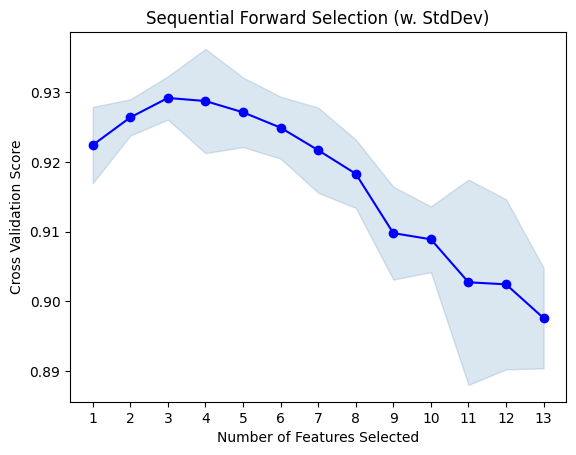

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Sequential forward selection
sfs = SFS(dt,
          k_features='best',  # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)  # using 5-fold cross-validation

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Mendapatkan nama fitur yang dipilih
feature_names = new_data.drop('stroke', axis=1).columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])

    # Mengubah x_train_scaled kembali menjadi DataFrame
    x_train_df = pd.DataFrame(x_train_scaled, columns=feature_names)
    x_selected = x_train_df.iloc[:, selected_indices]

    dt.fit(x_selected, y_train)
    y_pred = dt.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()

In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 9
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'smoking_status', 'age_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0   3411.0
1                   1.0     1.0       1.0   3394.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   6805.0
weighted avg        1.0     1.0       1.0   6805.0


### SFS-BACKWARD

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411
           1       1.00      1.00      1.00      3394

    accuracy                           1.00      6805
   macro avg       1.00      1.00      1.00      6805
weighted avg       1.00      1.00      1.00      6805



Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411


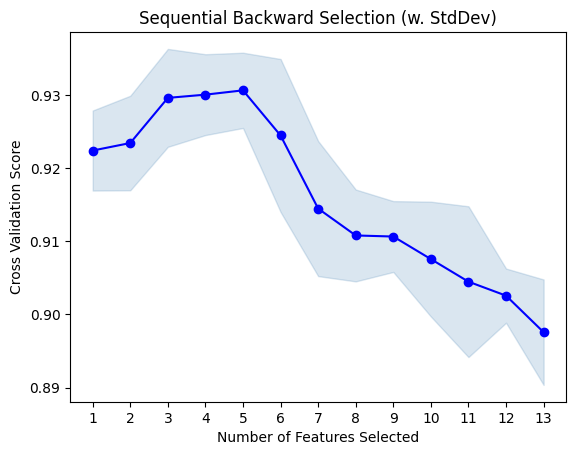

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Sequential backward selection
sfs = SFS(dt,
          k_features='best',  # number of features to select
          forward=False,  # Set backward selection
          floating=False,
          scoring='accuracy',  # Consider F1-score for imbalanced classes
          cv=5)  # using cross-validation for more robust feature selection

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Get feature names
feature_names = x.columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])
    x_selected = x_train_scaled[:, selected_indices]

    dt.fit(x_selected, y_train)
    y_pred = dt.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot the model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()


In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0   3411.0
1                   1.0     1.0       1.0   3394.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   6805.0
weighted avg        1.0     1.0       1.0   6805.0


## 3. NAIVE BAYES

###CHI SQUARE

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

results = []
num_features = x_train_scaled.shape[1]

for k in range(1, num_features + 1):
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_train = chi2_selector.fit_transform(x_train_scaled, y_train)
    X_kbest_test = chi2_selector.transform(x_test_scaled)
    selected_indices = chi2_selector.get_support(indices=True)
    selected_features = [x_train_df.columns[i] for i in selected_indices]

    nb = GaussianNB()
    nb.fit(X_kbest_train, y_train)

    y_pred_test = nb.predict(X_kbest_test)

    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']


    results.append((k, selected_features, accuracy_from_report, y_pred_test))

    # Displaying results for the current number of features
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_features}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    print("\n")

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.783339046966061
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1450
           1       0.73      0.89      0.81      1467

    accuracy                           0.78      2917
   macro avg       0.80      0.78      0.78      2917
weighted avg       0.80      0.78      0.78      2917



Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.7490572505999314
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1450
           1       0.76      0.73      0.75      1467

    accuracy                           0.75      2917
   macro avg       0.75      0.75      0.75      2917
weighted avg       0.75      0.75      0.75      2917



Number of features selected: 3
Selected features: ['age', 'Residence_type', 'age_category']
Mod

In [ ]:
# Menentukan hasil terbaik berdasarkan akurasi
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, y_pred_test = best_result
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(classification_report(y_test, y_pred_test, zero_division=0))

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.7853959547480288
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1450
           1       0.76      0.83      0.80      1467

    accuracy                           0.79      2917
   macro avg       0.79      0.79      0.78      2917
weighted avg       0.79      0.79      0.78      2917



### SFS-FORWARD

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.7694342395297575
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74      3411
           1       0.72      0.88      0.79      3394

    accuracy                           0.77      6805
   macro avg       0.78      0.77      0.77      6805
weighted avg       0.78      0.77      0.77      6805



Number of features selected: 2
Selected features: ['age', 'bmi_category']
Model Accuracy: 0.776781778104335
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.66      0.75      3411
           1       0.72      0.90      0.80      3394

    accuracy                           0.78      6805
   macro avg       0.79      0.78      0.77      6805
weighted avg       0.79      0.78      0.77      6805



Number of features selected: 3
Selected features: ['age', 'Residence_type', 'bmi_category']
Mod

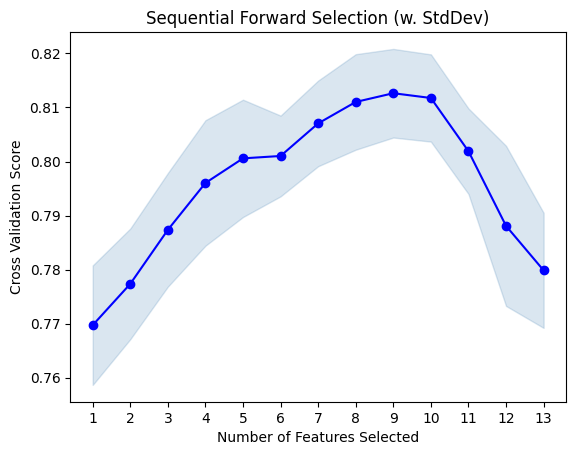

In [ ]:

from sklearn.naive_bayes import GaussianNB

# Naive Bayes classifier
nb = GaussianNB()

# Sequential forward selection
sfs = SFS(nb,
          k_features='best',  # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)  # using 5-fold cross-validation

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Mendapatkan nama fitur yang dipilih
feature_names = new_data.drop('stroke', axis=1).columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])

    # Mengubah x_train_scaled kembali menjadi DataFrame
    x_train_df = pd.DataFrame(x_train_scaled, columns=feature_names)
    x_selected = x_train_df.iloc[:, selected_indices]

    nb.fit(x_selected, y_train)
    y_pred = nb.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()


In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 10
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'bmi_category']
Model Accuracy: 0.8136664217487142
Classification Report:
              precision    recall  f1-score      support
0              0.866074  0.743184  0.799937  3411.000000
1              0.774110  0.884502  0.825633  3394.000000
accuracy       0.813666  0.813666  0.813666     0.813666
macro avg      0.820092  0.813843  0.812785  6805.000000
weighted avg   0.820207  0.813666  0.812753  6805.000000


### SFS-BACKWARD

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.7803085966201323
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      3411
           1       0.75      0.84      0.79      3394

    accuracy                           0.78      6805
   macro avg       0.78      0.78      0.78      6805
weighted avg       0.78      0.78      0.78      6805



Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'glucose_category', 'bmi_category']
Model Accuracy: 0.7895664952240999
Classification Report:
              precision    recall  f1-score   support

           0       0.8

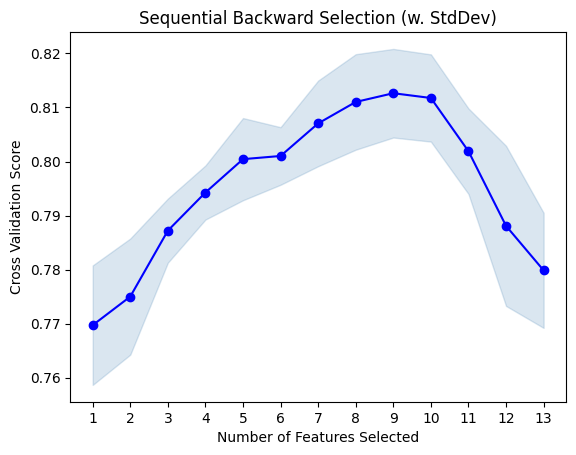

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes classifier
nb = GaussianNB()

# Sequential backward selection
sfs = SFS(nb,
          k_features='best',  # number of features to select
          forward=False,  # Set backward selection
          floating=False,
          scoring='accuracy',  # Consider F1-score for imbalanced classes
          cv=5)  # using cross-validation for more robust feature selection

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Get feature names
feature_names = x.columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])
    x_selected = x_train_scaled[:, selected_indices]

    nb.fit(x_selected, y_train)
    y_pred = nb.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot the model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()

In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 10
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'bmi_category']
Model Accuracy: 0.8136664217487142
Classification Report:
              precision    recall  f1-score      support
0              0.866074  0.743184  0.799937  3411.000000
1              0.774110  0.884502  0.825633  3394.000000
accuracy       0.813666  0.813666  0.813666     0.813666
macro avg      0.820092  0.813843  0.812785  6805.000000
weighted avg   0.820207  0.813666  0.812753  6805.000000


## 4. RANDOM FOREST

###CHI SQUARE

In [ ]:
from sklearn.ensemble import RandomForestClassifier

results = []

for k in range(1, num_features + 1):
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_train = chi2_selector.fit_transform(x_train_scaled, y_train)
    X_kbest_test = chi2_selector.transform(x_test_scaled)
    selected_indices = chi2_selector.get_support(indices=True)
    selected_features = [x_train_df.columns[i] for i in selected_indices]

    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_kbest_train, y_train)

    y_pred_test = rf.predict(X_kbest_test)

    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']


    results.append((k, selected_features, accuracy_from_report, report))

# Displaying results for the best number of features
for result in results:
    k, selected_features, accuracy_from_report, report = result
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_features}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    print("\n")


Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.9256085018854988
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1450
           1       0.95      0.97      0.96      1467

    accuracy                           0.95      2917
   macro avg       0.95      0.95      0.95      2917
weighted avg       0.95      0.95      0.95      2917



Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.9266369557764826
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1450
           1       0.95      0.97      0.96      1467

    accuracy                           0.95      2917
   macro avg       0.95      0.95      0.95      2917
weighted avg       0.95      0.95      0.95      2917



Number of features selected: 3
Selected features: ['age', 'Residence_type', 'age_category']
Mo

In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report = best_result
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(classification_report(y_test, rf.predict(chi2_selector.transform(x_test_scaled)), zero_division=0))

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.954748028796709
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1450
           1       0.95      0.97      0.96      1467

    accuracy                           0.95      2917
   macro avg       0.95      0.95      0.95      2917
weighted avg       0.95      0.95      0.95      2917



### SFS-FORWARD

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.9341660543717855
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3411
           1       0.93      0.94      0.93      3394

    accuracy                           0.93      6805
   macro avg       0.93      0.93      0.93      6805
weighted avg       0.93      0.93      0.93      6805



Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.9341660543717855
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3411
           1       0.93      0.94      0.93      3394

    accuracy                           0.93      6805
   macro avg       0.93      0.93      0.93      6805
weighted avg       0.93      0.93      0.93      6805



Number of features selected: 3
Selected features: ['age', 'heart_disease', 'age_category']
Mod

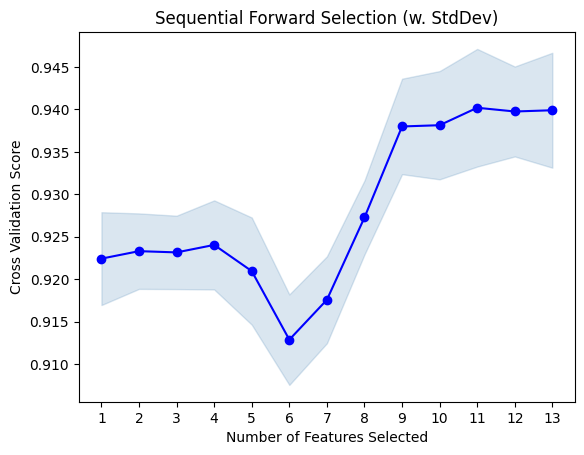

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf = RandomForestClassifier(random_state=42)

# Sequential forward selection
sfs = SFS(rf,
          k_features='best',  # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)  # using 5-fold cross-validation

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Mendapatkan nama fitur yang dipilih
feature_names = new_data.drop('stroke', axis=1).columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])

    # Mengubah x_train_scaled kembali menjadi DataFrame
    x_train_df = pd.DataFrame(x_train_scaled, columns=feature_names)
    x_selected = x_train_df.iloc[:, selected_indices]

    rf.fit(x_selected, y_train)
    y_pred = rf.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()

In [ ]:
# Menentukan hasil terbaik
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_feature_names, accuracy_from_report, report, y_pred
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_feature_names}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(classification_report(y_train, y_pred, zero_division=0))

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411
           1       1.00      1.00      1.00      3394

    accuracy                           1.00      6805
   macro avg       1.00      1.00      1.00      6805
weighted avg       1.00      1.00      1.00      6805



### SFS-BACKWARD

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411
           1       1.00      1.00      1.00      3394

    accuracy                           1.00      6805
   macro avg       1.00      1.00      1.00      6805
weighted avg       1.00      1.00      1.00      6805



Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411

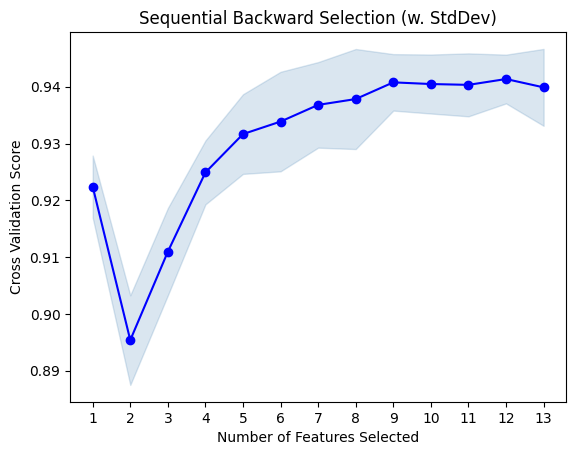

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Sequential backward selection
sfs = SFS(clf,
          k_features='best',  # number of features to select
          forward=False,  # Set backward selection
          floating=False,
          scoring='accuracy',  # Consider F1-score for imbalanced classes
          cv=5)  # using cross-validation for more robust feature selection

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Get feature names
feature_names = x.columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])
    x_selected = x_train_scaled[:, selected_indices]

    clf.fit(x_selected, y_train)
    y_pred = clf.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot the model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()


In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 1.0
Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0   3411.0
1                   1.0     1.0       1.0   3394.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   6805.0
weighted avg        1.0     1.0       1.0   6805.0


## 5. XGBOOST

###CHI SQUARE

In [ ]:
from xgboost import XGBClassifier

results = []

for k in range(1, num_features + 1):
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_train = chi2_selector.fit_transform(x_train_scaled, y_train)
    X_kbest_test = chi2_selector.transform(x_test_scaled)
    selected_indices = chi2_selector.get_support(indices=True)
    selected_features = [x_train_df.columns[i] for i in selected_indices]

    xgb = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_kbest_train, y_train)

    y_pred_test = xgb.predict(X_kbest_test)

    report = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    # Menyimpan hasil untuk setiap iterasi ke dalam daftar results
    results.append((k, selected_features, accuracy_from_report, report))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_features}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=0))
    print("\n")


Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.8594446348988687
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1450
           1       0.90      0.82      0.85      1467

    accuracy                           0.86      2917
   macro avg       0.86      0.86      0.86      2917
weighted avg       0.86      0.86      0.86      2917



Number of features selected: 2
Selected features: ['age', 'age_category']
Model Accuracy: 0.8663009941720946
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1450
           1       0.90      0.83      0.86      1467

    accuracy                           0.87      2917
   macro avg       0.87      0.87      0.87      2917
weighted avg       0.87      0.87      0.87      2917



Number of features selected: 3
Selected features: ['age', 'Residence_type', 'age_category']
Mo

In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report = best_result
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(classification_report(y_test, rf.predict(chi2_selector.transform(x_test_scaled)), zero_division=0))

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.9568049365786767
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1450
           1       0.94      0.96      0.95      1467

    accuracy                           0.95      2917
   macro avg       0.95      0.95      0.95      2917
weighted avg       0.95      0.95      0.95      2917



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### SFS-FORWARD

Number of features selected: 1
Selected features: ['age']
Model Accuracy: 0.8536370315944158
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3411
           1       0.89      0.81      0.85      3394

    accuracy                           0.85      6805
   macro avg       0.86      0.85      0.85      6805
weighted avg       0.86      0.85      0.85      6805



Number of features selected: 2
Selected features: ['age', 'avg_glucose_level']
Model Accuracy: 0.9421013960323291
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3411
           1       0.95      0.94      0.94      3394

    accuracy                           0.94      6805
   macro avg       0.94      0.94      0.94      6805
weighted avg       0.94      0.94      0.94      6805



Number of features selected: 3
Selected features: ['age', 'avg_glucose_level', 'bmi']
Mod

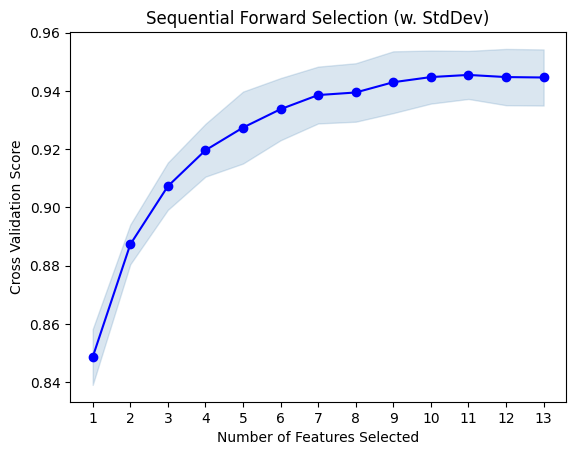

In [ ]:
from xgboost import XGBClassifier

# XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)  # Adjust parameters as needed

# Sequential forward selection

# Sequential forward selection
sfs = SFS(xgb,
          k_features='best',  # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)  # using 5-fold cross-validation

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Mendapatkan nama fitur yang dipilih
feature_names = new_data.drop('stroke', axis=1).columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])

    # Mengubah x_train_scaled kembali menjadi DataFrame
    x_train_df = pd.DataFrame(x_train_scaled, columns=feature_names)
    x_selected = x_train_df.iloc[:, selected_indices]

    xgb.fit(x_selected, y_train)
    y_pred = xgb.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()


In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 12
Selected features: ['gender', 'age', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.9975018368846437
Classification Report:
              precision    recall  f1-score      support
0              0.997362  0.997655  0.997508  3411.000000
1              0.997642  0.997348  0.997495  3394.000000
accuracy       0.997502  0.997502  0.997502     0.997502
macro avg      0.997502  0.997501  0.997502  6805.000000
weighted avg   0.997502  0.997502  0.997502  6805.000000


### SFS-BACKWARD

Number of features selected: 13
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'glucose_category', 'bmi_category']
Model Accuracy: 0.9966201322556943
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3411
           1       1.00      1.00      1.00      3394

    accuracy                           1.00      6805
   macro avg       1.00      1.00      1.00      6805
weighted avg       1.00      1.00      1.00      6805



Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'bmi_category']
Model Accuracy: 0.9969140337986775
Classification Report:
              precision    recall  f1-score   support

           0       1.00   

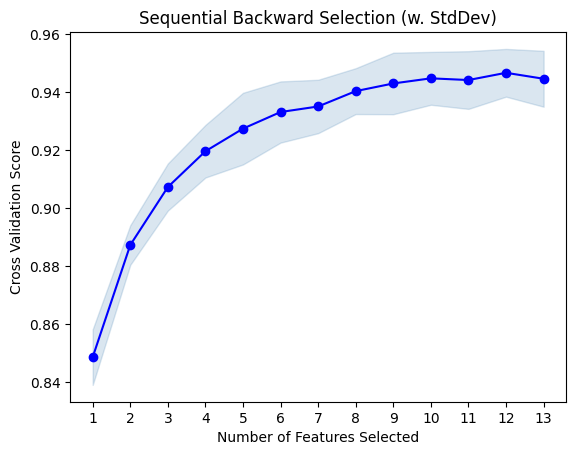

In [ ]:
from xgboost import XGBClassifier

# XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)  # Adjust parameters as needed

# Sequential backward selection
sfs = SFS(xgb,
          k_features='best',  # number of features to select
          forward=False,  # Set backward selection
          floating=False,
          scoring='accuracy',  # Consider F1-score for imbalanced classes
          cv=5)  # using cross-validation for more robust feature selection

sfs.fit(x_train_scaled, y_train)

results = []

metric_dict = sfs.get_metric_dict()

# Get feature names
feature_names = x.columns

for k, subset in sfs.subsets_.items():
    selected_indices = list(subset['feature_idx'])
    x_selected = x_train_scaled[:, selected_indices]

    xgb.fit(x_selected, y_train)
    y_pred = xgb.predict(x_selected)

    selected_feature_names = [feature_names[i] for i in selected_indices]
    report = classification_report(y_train, y_pred, output_dict=True, zero_division=0)
    accuracy_from_report = report['accuracy']

    results.append((k, selected_feature_names, accuracy_from_report, report, y_pred))

    # Menampilkan hasil untuk setiap jumlah fitur
    print(f'Number of features selected: {k}')
    print(f'Selected features: {selected_feature_names}')
    print(f'Model Accuracy: {accuracy_from_report}')
    print("Classification Report:")
    print(classification_report(y_train, y_pred, zero_division=0))
    print("\n")

# Plot the model accuracy
plot_sfs(metric_dict, kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score')
plt.show()

In [ ]:
best_result = max(results, key=lambda x: x[2])

# Menampilkan hasil terbaik
k, selected_features, accuracy_from_report, report, y_pred = best_result
print("Best Result:")
print(f'Number of features selected: {k}')
print(f'Selected features: {selected_features}')
print(f'Model Accuracy: {accuracy_from_report}')
print("Classification Report:")
print(pd.DataFrame(report).transpose())

Best Result:
Number of features selected: 12
Selected features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'age_category', 'bmi_category']
Model Accuracy: 0.9969140337986775
Classification Report:
              precision    recall  f1-score      support
0              0.998236  0.995602  0.996918  3411.000000
1              0.995592  0.998232  0.996910  3394.000000
accuracy       0.996914  0.996914  0.996914     0.996914
macro avg      0.996914  0.996917  0.996914  6805.000000
weighted avg   0.996918  0.996914  0.996914  6805.000000
